<a href="https://colab.research.google.com/github/brendanhasz/tfp-taxi/blob/master/TFP_Taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO: intro...

In [0]:
!pip install -q tf-nightly
!pip install -q tfp-nightly
!pip install -q catboost

In [0]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from scipy.stats import norm
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict
from catboost import CatBoostRegressor
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

# Settings
sns.set()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%config InlineBackend.figure_format = 'svg'
np.random.seed(111)
tf.set_random_seed(111)

## Data

TODO: intro

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Load data
#train = pd.read_csv('train.csv', 
train = pd.read_csv('/content/gdrive/My Drive/DataScience/Data/train.zip', 
                    usecols=np.arange(1, 7),
                    nrows=200000)

# Convert pickup time column to datetime
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'],
                                          format='%Y-%m-%d %H:%M:%S %Z')

In [0]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762


Let's take a look at how many null values there are in each column.

In [0]:
print('Column\tPercent Null')
for col in train:
    print(col, 100*train[col].isnull().sum()/train.shape[0])

Column	Percent Null
fare_amount 0.0
pickup_datetime 0.0
pickup_longitude 0.0
pickup_latitude 0.0
dropoff_longitude 0.0005
dropoff_latitude 0.0005


There are some null values, but a negligible amount of them, so we'll simply remove rows with null values.

In [0]:
train.dropna(inplace=True)

Have to extract time of day, time of week, time of year, and year, and then drop the original datetime column.

In [0]:
train['min_of_day'] = (60*train['pickup_datetime'].dt.hour + 
                       train['pickup_datetime'].dt.minute)
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek
train['day_of_year'] = train['pickup_datetime'].dt.dayofyear
train['year'] = train['pickup_datetime'].dt.year
train.drop('pickup_datetime', axis=1, inplace=True)

In [0]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,min_of_day,day_of_week,day_of_year,year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1046,0,166,2009
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1012,1,5,2010
2,5.7,-73.982738,40.761270,-73.991242,40.750562,35,3,230,2011
3,7.7,-73.987130,40.733143,-73.991567,40.758092,270,5,112,2012
4,5.3,-73.968095,40.768008,-73.956655,40.783762,471,1,68,2010


Let's check the fare amount distributions:

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


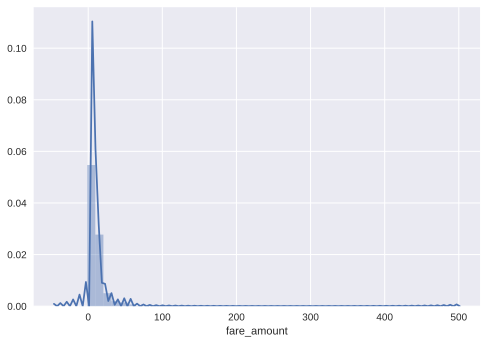

In [0]:
# Plot distribution of fares
sns.distplot(train['fare_amount'])
plt.show()

It looks like there might be some negative values (which doesn't make any sense, of course!). Let's zoom in on the area around 0.

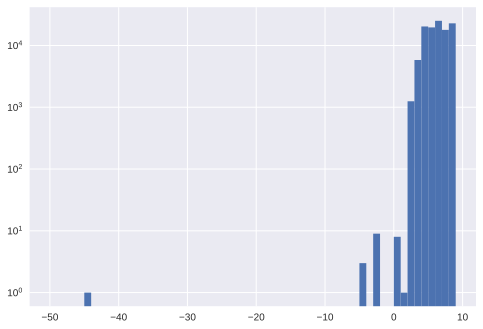

In [0]:
# Plot distribution of fares around 0
plt.hist(train['fare_amount'], 
         bins=np.arange(-50, 10), log=True)
plt.show()

Let's remove the datapoints with fares which are suspiciously low, and also rides with suspiciously high fares.

In [0]:
# Function to remove rows outside range
def clip(df, a, b, col):
    for c in col:
        df = df[(df[c]>a) & (df[c]<b)]
    return df

# Remove rows with outlier fare values
train = clip(train, 1, 200, ['fare_amount'])

Finally, let's check the locations of the pickups and dropoffs.

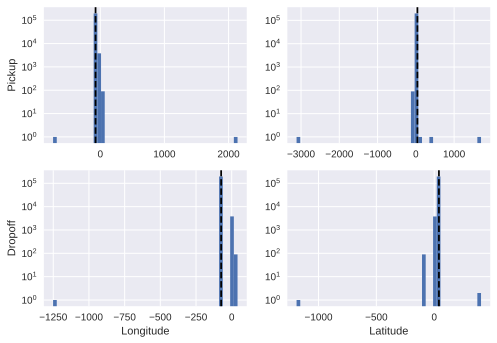

In [0]:
# Plot distribution of pickup longitudes
fig, ax = plt.subplots(2, 2)
nyc_lon = -74
nyc_lat = 40.7
ax[0,0].axvline(nyc_lon, linestyle='--', color='k')
ax[0,0].hist(train['pickup_longitude'], bins=50, log=True)
ax[0,0].set_ylabel('Pickup')
ax[1,0].axvline(nyc_lon, linestyle='--', color='k')
ax[1,0].hist(train['dropoff_longitude'], bins=50, log=True)
ax[1,0].set_xlabel('Longitude')
ax[1,0].set_ylabel('Dropoff')
ax[0,1].axvline(nyc_lat, linestyle='--', color='k')
ax[0,1].hist(train['pickup_latitude'], bins=50, log=True)
ax[1,1].axvline(nyc_lat, linestyle='--', color='k')
ax[1,1].hist(train['dropoff_latitude'], bins=50, log=True)
ax[1,1].set_xlabel('Latitude')
plt.show()

There are some outliers, especially at 0.  Let's remove rows with geographical locations outside a reasonable range (near the greater NYC metropolitan area).

In [0]:
# Remove geographical outliers
train = clip(train,  -75, -72.5,
             ['pickup_longitude', 'dropoff_longitude'])
train = clip(train, 40, 41.5,
             ['pickup_latitude', 'dropoff_latitude'])

And now we have only values which are near NYC:

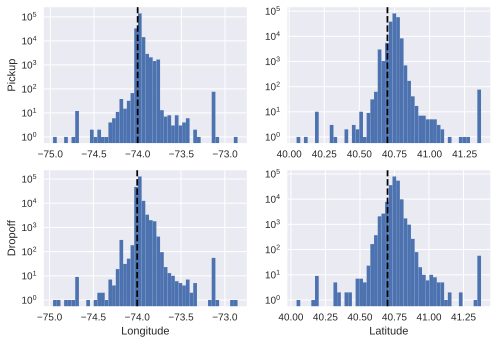

In [0]:
# Plot distribution of pickup longitudes
fig, ax = plt.subplots(2, 2)
nyc_lon = -74
nyc_lat = 40.7
ax[0,0].axvline(nyc_lon, linestyle='--', color='k')
ax[0,0].hist(train['pickup_longitude'], bins=50, log=True)
ax[0,0].set_ylabel('Pickup')
ax[1,0].axvline(nyc_lon, linestyle='--', color='k')
ax[1,0].hist(train['dropoff_longitude'], bins=50, log=True)
ax[1,0].set_xlabel('Longitude')
ax[1,0].set_ylabel('Dropoff')
ax[0,1].axvline(nyc_lat, linestyle='--', color='k')
ax[0,1].hist(train['pickup_latitude'], bins=50, log=True)
ax[1,1].axvline(nyc_lat, linestyle='--', color='k')
ax[1,1].hist(train['dropoff_latitude'], bins=50, log=True)
ax[1,1].set_xlabel('Latitude')
plt.show()

## Baseline Model



In [0]:
# Separate in- from dependent variables
x_taxi = train.drop('fare_amount', axis=1)
y_taxi = train['fare_amount']

# Make Mean Absolute Error scorer
mae_scorer = make_scorer(mean_absolute_error)

# Function to print cross-validated mean abs deviation
def cv_mae(regressor, x, y, cv=3, scorer=mae_scorer):
    scores = cross_val_score(regressor, 
                             x, y, cv=cv,
                             scoring=scorer)
    print('MAE:', scores.mean())

How well do we do if we just predict the mean?

In [0]:
# MAE from predicting just the mean
cv_mae(DummyRegressor(), x_taxi, y_taxi)

MAE: 5.998819370125794


And if we just use the distance of the trip as a predictor?

In [0]:
# Distance between pickup and dropoff locations
dist = np.sqrt(
    np.power(train['pickup_longitude'] -
             train['dropoff_longitude'], 2) + 
    np.power(train['pickup_latitude'] - 
             train['dropoff_latitude'], 2))

# MAE from using just distance as predictor
cv_mae(IsotonicRegression(out_of_bounds='clip'), 
       dist, y_taxi)

MAE: 2.327178870427959


And we can do a little better if we use gradient boosted decision trees.

In [0]:
# Cross-validated MAE w/ CatBoost
cv_mae(CatBoostRegressor(logging_level='Silent'), 
       x_taxi, y_taxi)

MAE: 2.0682634529018107


## Uncertainty under Heteroskedasticity

What if we now want to predict our uncertainty as to our estimate?

But need to look out for heteroskedasticity!  Explain heteroskedasticity

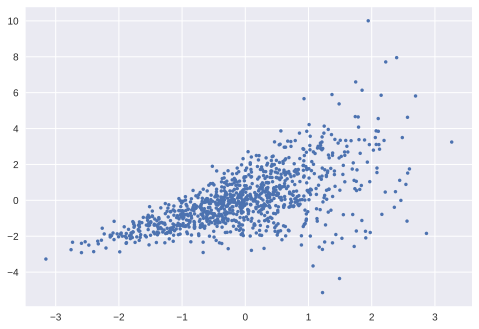

In [0]:
# A function to generate heteroskedastic data
def h_func(x):
    return x + np.exp(0.5*x)*np.random.randn(x.shape[0],1)

# Generate heteroskedastic data
N = 1000
xx = np.atleast_2d(np.random.randn(N)).T
yy = h_func(xx).ravel()

# Generate validation data
xx_val = np.atleast_2d(np.linspace(-3, 3, N)).T
yy_val = h_func(xx_val).ravel()

# Plot data we generated
plt.plot(xx, yy, '.')
plt.show()

Is the true data heteroskedastic?

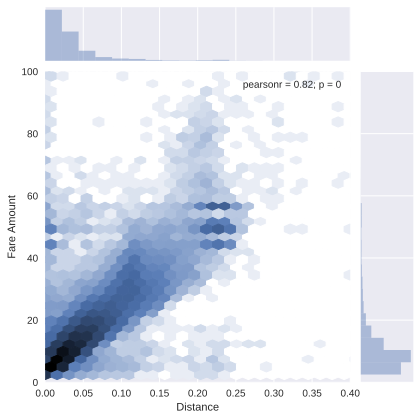

In [0]:
# Plot distance vs fare
sns.jointplot('Distance', 'Fare Amount',
              pd.DataFrame({'Distance':dist, 
                            'Fare Amount':y_taxi}), 
              kind="hex",
              xlim=(0, 0.4), ylim=(0, 100),
              joint_kws=dict(gridsize=70, bins='log'))

Indeed it looks like the true data is heteroskedastic.  And keep in mind this is only the *distance*, whereas the full dataset has pickup/dropoff location, time of day, time of year, etc.  The y-values could be heteroskedastic as a function of those predictors as well!

How can we account for this uncertainty, especially when it is varying with our independent variables?  One way which can be used with gradient boosted decision trees is to do a quantile regression.

Explain quantile loss, penalizes y_pred>y_true more than y_true>y_pred when quantile<0.5 and vice-versa.  Eqs etc

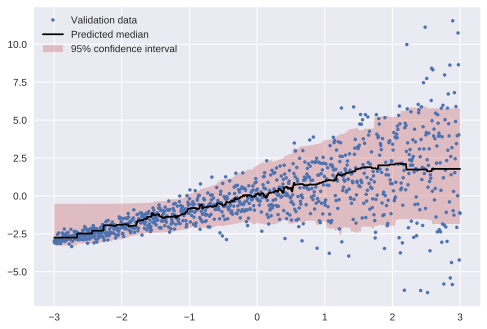

In [0]:
# Gradient boosted tree regressors w/ different quantile losses
gbrL = CatBoostRegressor(loss_function='Quantile:alpha=0.025', logging_level='Silent')
gbr = CatBoostRegressor(loss_function='Quantile:alpha=0.5', logging_level='Silent')
gbrH = CatBoostRegressor(loss_function='Quantile:alpha=0.975', logging_level='Silent')

# Using scikit-learn's gradient boosted decision trees
#from sklearn.ensemble import GradientBoostingRegressor
#gbrL = GradientBoostingRegressor(loss='quantile', alpha=0.025)
#gbr = GradientBoostingRegressor(loss='quantile', alpha=0.5)
#gbrH = GradientBoostingRegressor(loss='quantile', alpha=0.975)

# Fit to data
gbrL.fit(xx, yy)
gbr.fit(xx, yy)
gbrH.fit(xx, yy)

# Predict on validation data
y_predL = gbrL.predict(xx_val)
y_pred = gbr.predict(xx_val)
y_predH = gbrH.predict(xx_val)

# Plot predictions over points
plt.figure()
plt.plot(xx_val, yy_val, '.',
         label='Validation data')
plt.fill_between(xx_val.ravel(), y_predL, y_predH,
                 alpha=0.3, facecolor=colors[1],
                 label='95% confidence interval')
plt.plot(xx_val, y_pred, 'k', label='Predicted median')
plt.legend()
plt.show()

To see how well-calibrated the model is, we can check the coverage of the 95% confidence interval (the percentage of y values from the validation dataset falling within our 95% predictive interval).  If the model is well-calibrated, the coverage will be near 95%.

In [0]:
# Function to compute coverage of predictive interval
def coverage(y, yL, yH):
     return (100 / yL.shape[0] *
             ((y>yL)&(y<yH)).sum())
    
# Compute coverage of the 95% interval
print('Coverage of 95%% predictive interval: %0.1f%%'
      % coverage(yy_val, y_predL, y_predH))

Coverage of 95% predictive interval: 91.0%


Hmm. OK but not great.  How does it look on the real data?

In [0]:
# Compute 2.5% and 97.5% predictive intervals
y_predL = cross_val_predict(gbrL, x_taxi, y_taxi)
y_predH = cross_val_predict(gbrH, x_taxi, y_taxi)

# Compute coverage of the 95% interval
print('Coverage of 95%% predictive interval: %0.1f%%'
      % coverage(y_taxi, y_predL, y_predH))

Coverage of 95% predictive interval: 81.5%


Eek.  Not so great at all :(

We could calibrate our model, or we could use a model which is more explicitly built to capture uncertainty accurately!

## Dual-module Bayesian Neural Network



In [0]:
# Settings
batch_size = 50
max_steps = 2000
learning_rate = 0.005

In [0]:
# DEBUGGER: reset the graph so you can re-run
tf.reset_default_graph() 

In [0]:
def build_input_pipeline(x, y, x_val, y_val, batch_size, N_val):
  '''Build an Iterator switching between train and heldout data.
  Args:
    x: Numpy `array` of training features, indexed by the first dimension.
    y: Numpy `array` of training labels, with the same first dimension as `x`.
    x_val: Numpy `array` of validation features, indexed by the first dimension.
    y_val: Numpy `array` of validation labels, with the same first dimension as `x_val`.
    batch_size: Number of elements in each training batch.
    N_val: Number of examples in the validation dataset
  Returns:
    batch_features: `Tensor` feed  features, of shape
      `[batch_size] + x.shape[1:]`.
    batch_labels: `Tensor` feed of labels, of shape
      `[batch_size] + y.shape[1:]`.
  '''
  # Build an iterator over training batches.
  training_dataset = tf.data.Dataset.from_tensor_slices((x, y))
  training_batches = training_dataset.shuffle(
      50000, reshuffle_each_iteration=True).repeat().batch(batch_size)
  train_iterator = training_batches.make_one_shot_iterator()

  # Build a iterator over the validation set with batch_size=N_val,
  # i.e., return the entire heldout set as a constant.
  val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  val_frozen = val_dataset.take(N_val).repeat().batch(N_val)
  val_iterator = val_frozen.make_one_shot_iterator()

  # Combine these into a feedable iterator that can switch between training
  # and validation inputs.
  handle = tf.placeholder(tf.string, shape=[])
  feedable_iterator = tf.data.Iterator.from_string_handle(
      handle, training_batches.output_types, training_batches.output_shapes)
  batch_features, batch_labels = feedable_iterator.get_next()

  return batch_features, batch_labels, handle, train_iterator, val_iterator

# Build input pipeline
x_vals, y_vals,  handle, training_iterator, validation_iterator = (
    build_input_pipeline(x, y, x_val, y_val, batch_size, N_val) )

In [0]:
# A dense network specified by a list of Nunits per layer
def DenseNetReg(layers, x_in)
  prior = tfp.layers.default_mean_field_normal_fn()
  for units in layers:
    layer = tfp.layers.DenseFlipout(
      units=units, 
      kernel_posterior_fn=prior,
      bias_posterior_fn=prior)
    x_in = layer(x_in)
  layer = tfp.layers.DenseFlipout( #final layer w/ no activation
      units=1, 
      activation=None,
      kernel_posterior_fn=prior,
      bias_posterior_fn=prior)
  return layer(x_in)

# A linear regression model: a Normal distribution
# parameterized by location from a dense multi-layer net,
# and std dev frmo a dense multi-layer net
with tf.name_scope("bayesian_regression", values=[x_vals]):
  predictions = DenseNetReg([32, 16, 8], x_vals)  
  noise_std = DenseNetReg([32, 16, 8], x_vals)  
  pred_distribution = tfd.Normal(loc=predictions, 
                                 scale=noise_std)

In [0]:
# Compute the -ELBO as the loss, averaged over the batch size
neg_log_likelihood = -tf.reduce_mean(pred_distribution.log_prob(y_vals))
kl_div = sum(layer.losses) / N
elbo_loss = neg_log_likelihood + kl_div

# Mean squared error metric for evaluation
mse, mse_update_op = tf.metrics.mean_squared_error(
    labels=y_vals, predictions=predictions)

# Use ADAM optimizer w/ -ELBO loss
with tf.name_scope("train"):
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  train_op = optimizer.minimize(elbo_loss)

In [0]:
# To store parameter values over training
weight_mean = layer.kernel_posterior.mean()[:,0]
weight_std = layer.kernel_posterior.stddev()[:,0]
bias_mean = layer.bias_posterior.mean()
bias_std = layer.bias_posterior.stddev()
noise_std_mean = noise_std.mean()
noise_std_std = noise_std.stddev()
weight_means = np.zeros((max_steps, D))
weight_stds = np.zeros((max_steps, D))
bias_means = np.zeros(max_steps)
bias_stds = np.zeros(max_steps)
noise_stds = np.zeros(max_steps)
noise_means = np.zeros(max_steps)
mses = np.zeros(max_steps)
losses = np.zeros(max_steps)

# Initialization op
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

# Run the training session
with tf.Session() as sess:
  sess.run(init_op)

  # Training loop
  train_handle = sess.run(training_iterator.string_handle())
  val_handle = sess.run(validation_iterator.string_handle())
  with Timer():
    for iS in range(max_steps):
      [
          _,
          _,
          mses[iS],
          losses[iS],
          weight_means[iS,:],
          weight_stds[iS,:],
          bias_means[iS],
          bias_stds[iS],
          noise_means[iS],
          noise_stds[iS]
      ] = sess.run([
          train_op,
          mse_update_op,
          mse,
          elbo_loss,
          weight_mean,
          weight_std,
          bias_mean,
          bias_std,
          noise_std_mean,
          noise_std_std
      ], feed_dict={handle: train_handle})

  # Draw samples from the posterior
  Nmc = 1000
  w_draw = layer.kernel_posterior.sample(Nmc)
  b_draw = layer.bias_posterior.sample(Nmc)
  n_draw = noise_std.sample(Nmc)
  w_post, b_post, n_post = sess.run([w_draw, b_draw, n_draw])
  
  # Draw predictive distribution samples
  prediction_dist_var = sess.run((pred_distribution.sample(Nmc)), 
                                 feed_dict={handle: val_handle})

In [0]:
# Compute proportion of estimates on validation data 
# which fall within the 95% prediction interval
q0 = 2.5
q1 = 97.5
within_conf_int = np.zeros(N_val)
for i in range(N_val):
  pred_dist = prediction_dist_var[:, i, 0]
  p0 = np.percentile(pred_dist, q0)
  p1 = np.percentile(pred_dist, q1)
  if p0<=y_val[i] and p1>y_val[i]:
    within_conf_int[i] = 1

print('%0.1f %% of validation samples are w/i the %0.1f %% prediction interval' 
      % (100*np.mean(within_conf_int), q1-q0))